In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from rubin_sim.satellite_constellations.sat_utils import starlink_tles_v1, starlink_tles_v2, create_constellation, Constellation, oneweb_tles
from skyfield.api import EarthSatellite
from skyfield.api import load, wgs84
import time
from mpl_toolkits import mplot3d
from rubin_sim.utils import gnomonic_project_toxy, _angularSeparation


In [3]:
class FullConst(Constellation):
    """keep the alt az computations even if unilumminated
    """
    def update_mjd(self, mjd):
        """
        Record the alt,az position and illumination status for all the satellites at a given time
        """
        MJDOFFSET = 2400000.5
        jd = mjd + MJDOFFSET
        t = self.ts.ut1_jd(jd)

        self.altitudes_rad = []
        self.azimuth_rad = []
        self.illum = []
        for sat in self.sat_list:
            current_sat = sat.at(t)
            illum = current_sat.is_sunlit(self.eph)
            self.illum.append(illum.copy())
            #if illum:
            topo = current_sat - self.observatory_site.at(t)
            alt, az, dist = topo.altaz()  # this returns an anoying Angle object
            self.altitudes_rad.append(alt.radians + 0)
            self.azimuth_rad.append(az.radians + 0)
            #else:
            #    self.altitudes_rad.append(np.nan)
            #    self.azimuth_rad.append(np.nan)

        self.altitudes_rad = np.array(self.altitudes_rad)
        self.azimuth_rad = np.array(self.azimuth_rad)
        self.illum = np.array(self.illum)
        # Keep track of the ones that are up and illuminated
        self.visible = np.where(
            (self.altitudes_rad >= self.alt_limit_rad) & (self.illum == True)
        )[0]

In [4]:
star_tles = starlink_tles_v1() #oneweb_constellation() #starlink_constellation_v1()
print(len(star_tles))



4408


In [5]:

constellations = {'Starlink v1': FullConst(starlink_tles_v1()),
                  'Starlink v2': FullConst(starlink_tles_v2()),
                  'OneWeb': FullConst(oneweb_tles())}


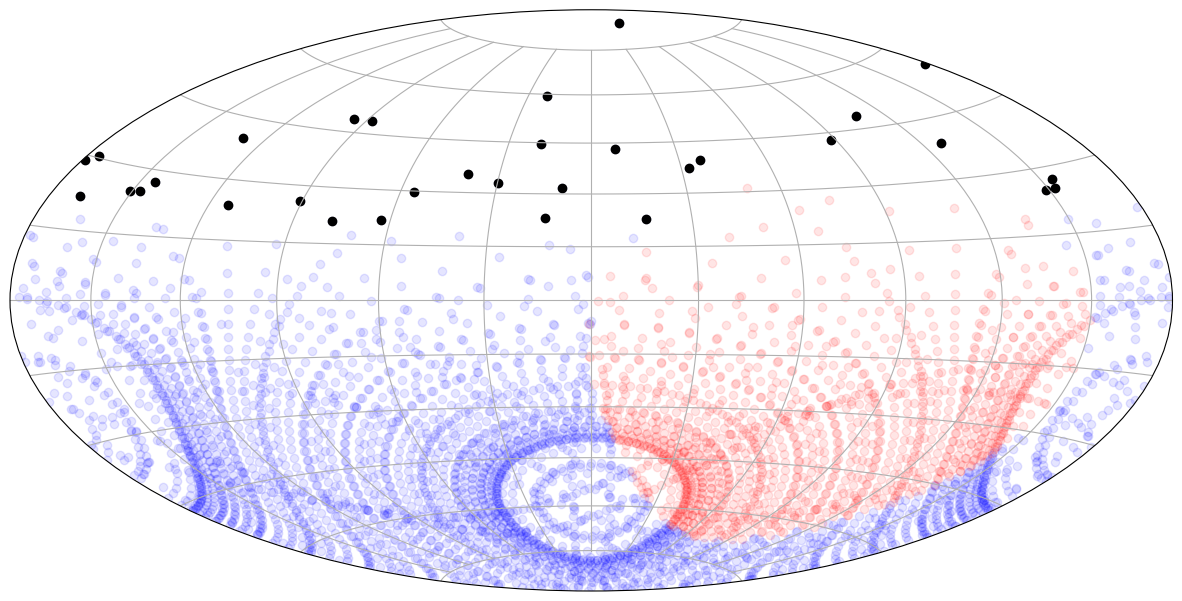

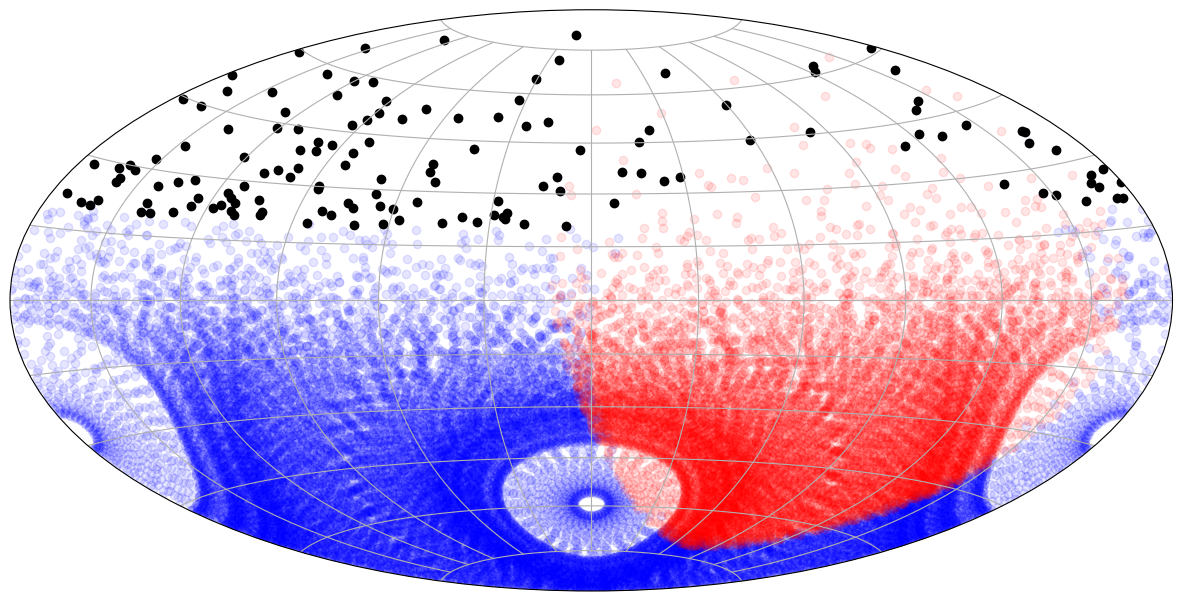

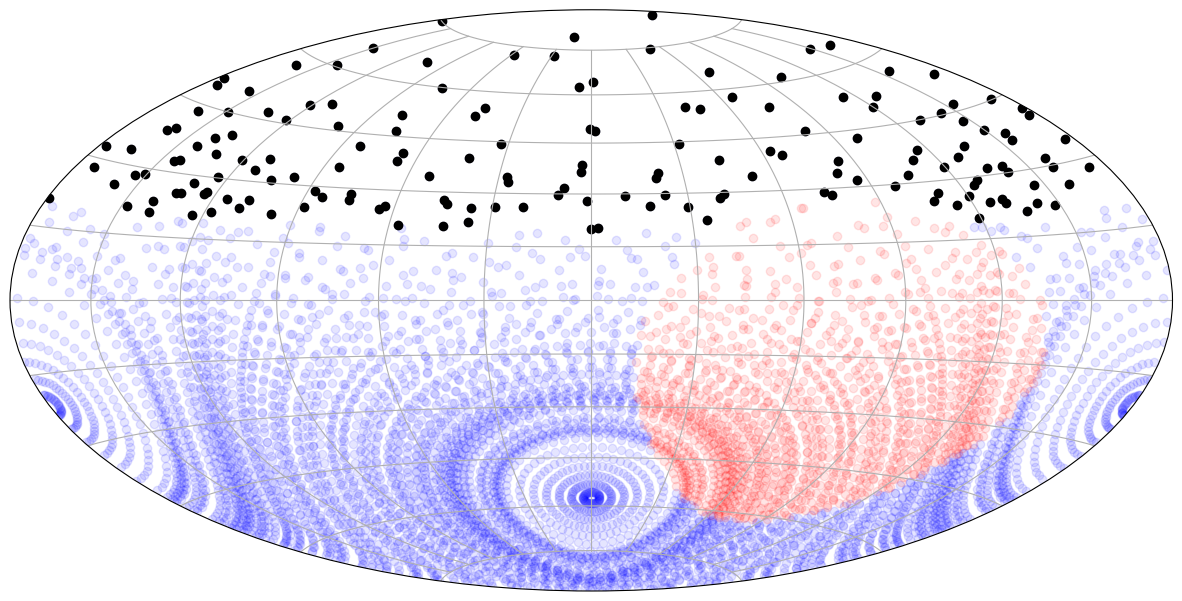

In [6]:
#fig, ax = plt.subplots(projection="hammer")
#ax.scatter(az.degrees, alt.degrees, facecolors='none', edgecolors='black', alpha=0.5)
#ax.scatter(az.degrees[illum], alt.degrees[illum], facecolors='black', edgecolors=None, alpha=0.5)
csfont = {'fontname':'Times New Roman'}

filenames={'Starlink v1': 'sats_slv1.pdf','Starlink v2':'sats_slv2.pdf', 'OneWeb':'sats_ow.pdf'}

for name in ['Starlink v1','Starlink v2', 'OneWeb']:
    
    const = constellations[name]
    
    const.update_mjd(60218.004) # sun Alt of -18 degrees
    
    az_temp = const.azimuth_rad + 0
    over = np.where(az_temp > np.pi)
    az_temp[over] -= 2.*np.pi

    illum = np.where(const.illum == True)
    no_illum = np.where(const.illum == False)
    
    plt.figure(figsize=(15,15))
    plt.subplot(projection="hammer")
    
    plt.scatter(az_temp[illum], const.altitudes_rad[illum], facecolors='blue', alpha=0.1, rasterized=True)
    plt.scatter(az_temp[no_illum], const.altitudes_rad[no_illum], facecolors='red', edgecolors=None, alpha=0.1, rasterized=True)
    plt.scatter(az_temp[const.visible], const.altitudes_rad[const.visible], facecolors='black', edgecolors='black', rasterized=True)
    # if name=='Starlink v1': 
    #     plot_name='Starlink Gen1'
    # elif name=='Starlink v2': 
    #     plot_name='Starlink Gen2'
    # else: 
    #     plot_name='OneWeb'

    # plt.title(plot_name,fontsize=60, **csfont)
    plt.grid(True)
    # plt.axis('off')
    plt.xticks([-2.61799388, -2.0943951 , -1.57079633, -1.04719755, -0.52359878,
        0.        ,  0.52359878,  1.04719755,  1.57079633,  2.0943951 ,
        2.61799388],[])
    plt.yticks([-1.30899694, -1.04719755, -0.78539816, -0.52359878, -0.26179939,
        0.        ,  0.26179939,  0.52359878,  0.78539816,  1.04719755,
        1.30899694],[])
    plt.grid(True)
    plt.savefig(filenames[name],bbox_inches='tight')

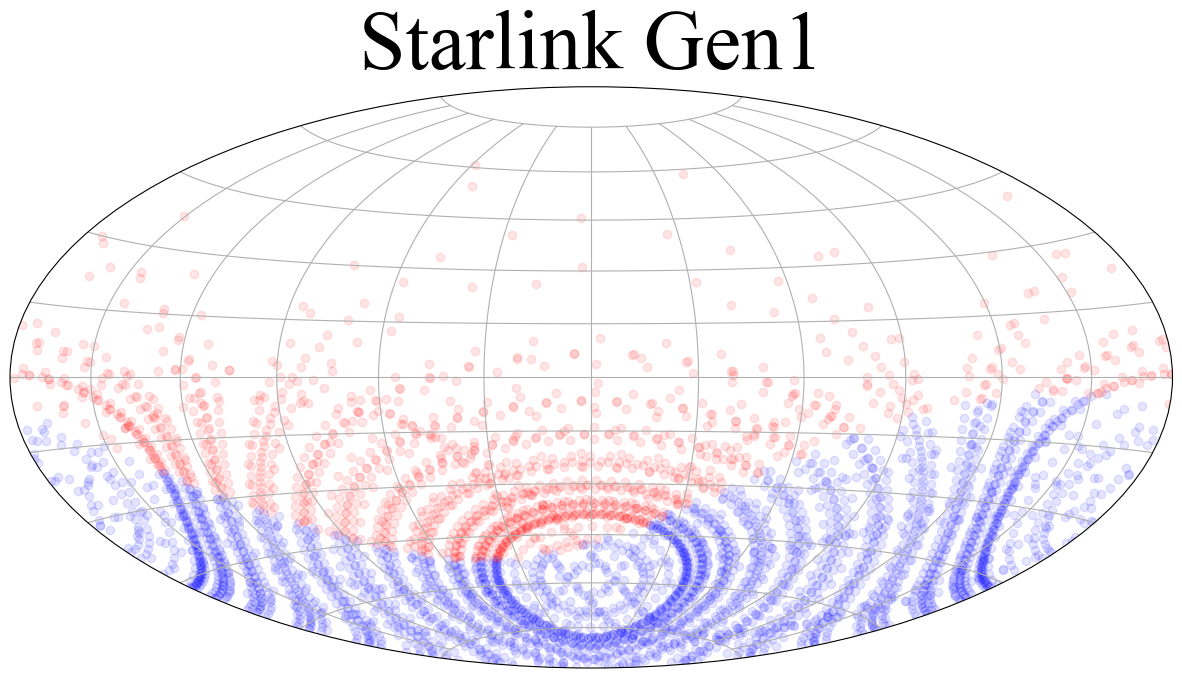

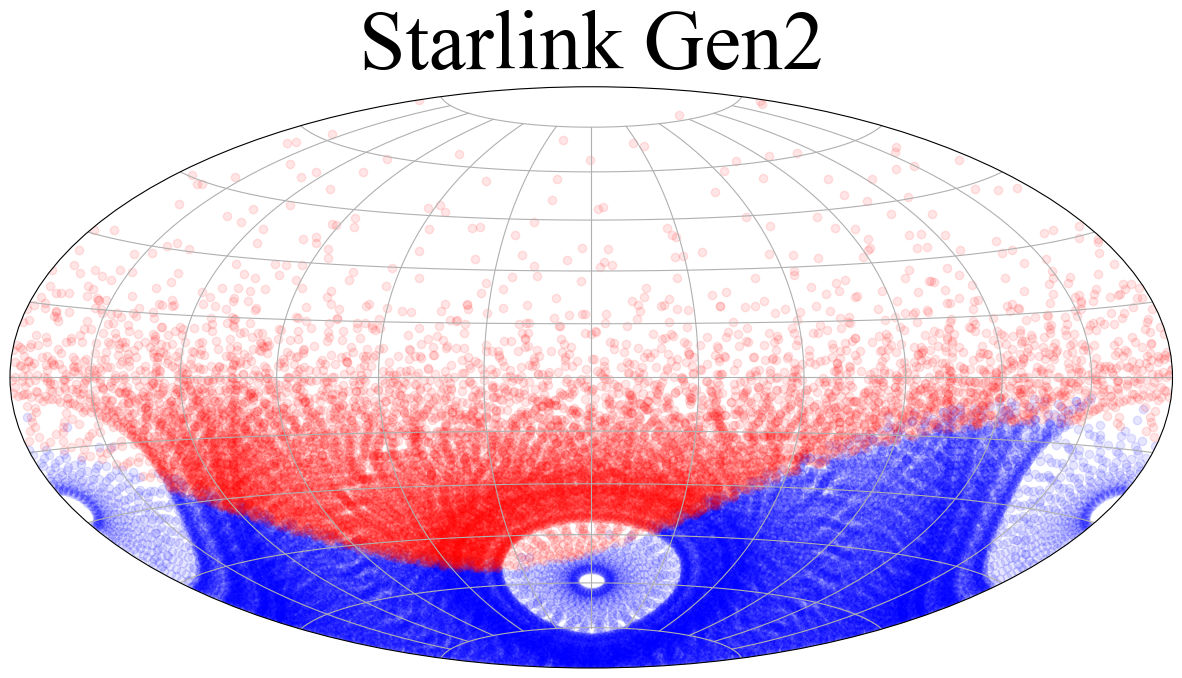

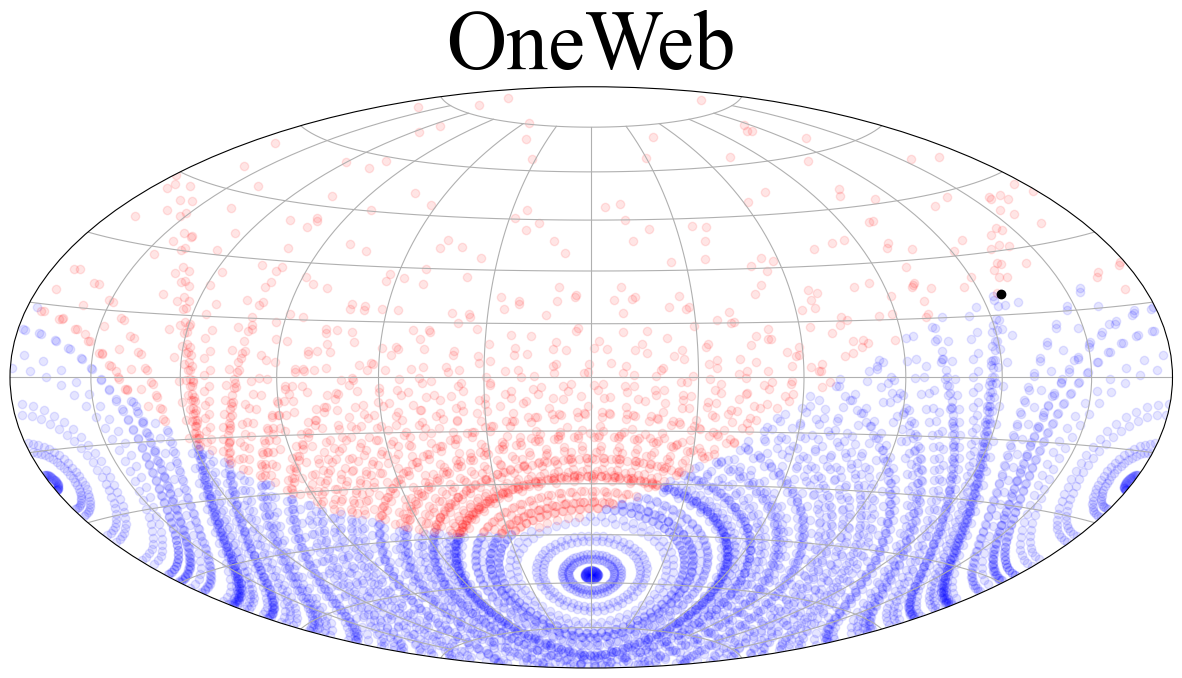

In [32]:
filenames={'Starlink v1': 'sats_slv1_late.pdf','Starlink v2':'sats_slv2_late.pdf', 'OneWeb':'sats_ow_late.pdf'}
csfont = {'fontname':'Times New Roman'}

for name in ['Starlink v1','Starlink v2', 'OneWeb']:
    
    const = constellations[name]
    
    const.update_mjd(60218.254) # 
    
    az_temp = const.azimuth_rad + 0
    over = np.where(az_temp > np.pi)
    az_temp[over] -= 2.*np.pi

    illum = np.where(const.illum == True)
    no_illum = np.where(const.illum == False)
    
    plt.figure(figsize=(15,15))
    plt.subplot(projection="hammer")
    
    plt.scatter(az_temp[illum], const.altitudes_rad[illum], facecolors='blue', alpha=0.1, rasterized=True)
    plt.scatter(az_temp[no_illum], const.altitudes_rad[no_illum], facecolors='red', edgecolors=None, alpha=0.1, rasterized=True)
    plt.scatter(az_temp[const.visible], const.altitudes_rad[const.visible], facecolors='black', edgecolors='black', rasterized=True)
    if name=='Starlink v1': 
        plot_name='Starlink Gen1'
    elif name=='Starlink v2': 
        plot_name='Starlink Gen2'
    else: 
        plot_name='OneWeb'
    plt.title(plot_name, fontsize=60, **csfont)
    plt.xticks([-2.61799388, -2.0943951 , -1.57079633, -1.04719755, -0.52359878,
        0.        ,  0.52359878,  1.04719755,  1.57079633,  2.0943951 ,
        2.61799388],[])
    plt.yticks([-1.30899694, -1.04719755, -0.78539816, -0.52359878, -0.26179939,
        0.        ,  0.26179939,  0.52359878,  0.78539816,  1.04719755,
        1.30899694],[])
    plt.grid(True)
    plt.savefig(filenames[name],bbox_inches='tight')

In [13]:
from rubin_sim.site_models import Almanac

In [15]:
almanac = Almanac(mjd_start=60218.004)
data = almanac.get_sun_moon_positions(60218.254)

In [17]:
np.degrees(data['sun_alt'])

-49.95554987874496

In [18]:
data = almanac.get_sun_moon_positions(60218.004)
np.degrees(data['sun_alt'])

-18.28088957752883